<a href="https://colab.research.google.com/github/shugad/my_DS_project/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Установка библиотек

In [47]:
!pip install fastparquet
!pip install -U lightautoml
!pip install shap

# Импорт библиотек

In [48]:
# standart libraries
import os
import sys
import pickle
import tqdm

# visualizations
import matplotlib.pyplot as plt

# DS libraries
import pandas as pd
import numpy as np

# ML libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import torch
import shap

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task

from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Вспомогательные функции

In [49]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# 1. Постановка задачи

Требуется: 
1. Провести разведочный анализ данных на индустриальных транзакционных данных.
2. Создать алгоритм, способный предсказывать наличие высшего образования у клиента. 

Данные для задачи предоставлены ВТБ для образовательной задачи ("Education") в рамках Data Fusion Contest 2022.

## Знакомство с данными

In [50]:
# импорт данных с Google Drive
!gdown 1Zf-wXxlKsjFHAE9Tree5uxpVqKb3FbQf
!gdown 1CxwXmQqS_R9kxmANIsPetu7qtaT1TpuZ
!gdown 1E26eo1ioB7eGYg9BPDDVo13zkOC_2zaV

Downloading...
From: https://drive.google.com/uc?id=1Zf-wXxlKsjFHAE9Tree5uxpVqKb3FbQf
To: /content/transactions.parquet
100% 352M/352M [00:13<00:00, 25.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CxwXmQqS_R9kxmANIsPetu7qtaT1TpuZ
To: /content/train.csv
100% 315k/315k [00:00<00:00, 3.02MB/s]
Downloading...
From: https://drive.google.com/uc?id=1E26eo1ioB7eGYg9BPDDVo13zkOC_2zaV
To: /content/sample_submission.csv
100% 148k/148k [00:00<00:00, 1.45MB/s]


**Транзакционные данные**

Основной файл с данными для задачи. Представлен в формате "одна строка - одна транзакция". Транзакции были совершены по банковским картам клиентов.

Столбцы таблицы:
1. user_id - уникальный ID клиента.
2. mcc_code - Merchant Category Code - код, классифицирующий вид торговой точки, где была совершена транзакция.
3. currency_rk - код валюты.
4. transaction_amt - сумма транзакции. Отрицательная сумма - списание с карты, положительная - зачисление на карту.
5. transaction_dttm - точное время момента совершения транзакции в формате "yy-MM-dd HH:mm:ss"

In [51]:
transactions = pd.read_parquet("/content/transactions.parquet", engine="fastparquet")

transactions = reduce_mem_usage(transactions) # уменьшаем размер датасета в памяти

transactions['transaction_dttm'] =  pd.to_datetime(transactions['transaction_dttm']) # конвертируем transaction_dttm в формат datetime64
transactions.head()

Memory usage of dataframe is 756.15 MB
Memory usage after optimization is: 453.69 MB
Decreased by 40.0%


,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.072296,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.313980,2020-08-05 01:27:40
2,000932580e404dafbecd5916d4640938,5499,48,-138.849808,2020-08-05 03:28:11
3,000932580e404dafbecd5916d4640938,4829,48,-309.476532,2020-08-06 00:36:29
4,000932580e404dafbecd5916d4640938,5411,48,-133.473694,2020-08-09 00:30:13


In [52]:
transactions.dtypes

user_id                     object
mcc_code                     int16
currency_rk                  int16
transaction_amt            float32
transaction_dttm    datetime64[ns]
dtype: object

 **Тренировочный датасет**

Файл для обучения модели. Представлен в виде "одна строка - один клиент".

Столбцы таблицы:

1. bank/user_id - уникальный ID клиента.
2. higher_education - целевая переменная, факт наличия у клиента высшего образования (1) или его отсутствия (0).

In [53]:
train = pd.read_csv("/content/train.csv")

train = train.rename(columns={'bank': 'user_id'}) # переименовываем столбик для сходимости с файлом transactions
train.head()

,user_id,higher_education
0,3755b59782464456bac1aec1a44e0db3,0.0
1,604a550439d644718ea6e1693fbf03dc,0.0
2,542d4776ebe5454fb8ab36f1c276fe0e,1.0
3,ee37fecea44d475ca030cde7ff7d545d,0.0
4,18617a1100f44a99b3a0772341fec3db,0.0


In [54]:
train.dtypes

user_id              object
higher_education    float64
dtype: object

**Тестовый датасет** 

Файл для тестирования модели с неизвестной целевой переменной (файл, необходимый для заполнения в рамках конкурса). Представлен в виде "одна строка - один клиент".

Столбцы таблицы:

1. bank/user_id - уникальный ID клиента.
2. higher_education_proba - целевая переменная, вероятность наличия у клиента высшего образования (prob > 0.5) или его отсутствия (prob < 0.5).

In [55]:
test = pd.read_csv("/content/sample_submission.csv")

test = test.rename(columns={'bank': 'user_id'}) # переименовываем столбик для сходимости с файлом transactions
test.head()

,user_id,higher_education_proba
0,85ef628894e34ad6869778a9a5d15ba5,0.5
1,5ec7a78c6efd4d6291e371a6f30ed5c0,0.5
2,d0f5d1884ad74e3e9aae7e49f2e1b77b,0.5
3,c3c0f24dda94413ab98036f6d9018d3d,0.5
4,6a137054df2a42218a518479317e5b1e,0.5


In [56]:
test.dtypes

user_id                    object
higher_education_proba    float64
dtype: object

_____________________

# 2. Feature Engineering

Перед тем, как приступить к анализу транзакционных данных, нужно создать полезные признаки на основе столбцов transaction_dttm и transaction_amt. Это позволит в дальнейшем получить больше информации (например, проследить динамику)  в разрезе различных измерений (таких, как время дня, дни недели и т.д.), а также использовать полученные признаки в моделях машинного обучения.

In [57]:
transactions['weekofyear'] = transactions['transaction_dttm'].dt.week.astype('int16') # номер недели в году
transactions['day_of_week'] = transactions['transaction_dttm'].dt.dayofweek.astype('int16') # номер дня недели
transactions['month'] = transactions['transaction_dttm'].dt.month.astype('int16') # номер месяца в году
transactions['day'] = transactions['transaction_dttm'].dt.day.astype('int16') # номер дня в месяце
transactions['hour'] = transactions['transaction_dttm'].dt.hour.astype('int16') # час от 0 до 24

transactions['is_afternoon'] = (transactions['hour'] > 12).astype('int16') # признак второй половины дня
transactions['early_morning'] = ((transactions['hour'] > 4) & (transactions['hour'] <= 8)).astype('int16') # признак "раннее утро"
# transactions['morning'] = ((transactions['hour'] > 8) & (transactions['hour'] <= 12)).astype('int16') # признак "утро"
# transactions['noon'] = ((transactions['hour'] > 12) & (transactions['hour'] <= 17)).astype('int16') # признак "день"
# transactions['eve'] = ((transactions['hour'] > 18) & (transactions['hour'] <= 21)).astype('int16') # признак "вечер"
# transactions['night'] = ((transactions['hour'] > 21) & (transactions['hour'] <= 24)).astype('int16') # признак "ночь"
# transactions['late_night'] = (transactions['hour'] <= 4).astype('int16') # признак "глубокая ночь"

transactions['is_weekend'] = (transactions['day_of_week'] > 4).astype('int16') # признак "выходной день"
# transactions['is_month_start'] = transactions['transaction_dttm'].dt.is_month_start.astype('int16') # признак "начало месяца"
# transactions['is_month_end'] = transactions['transaction_dttm'].dt.is_month_end.astype('int16') # признак "конец месяца"

transactions['transaction_dttm'] = transactions['transaction_dttm'].dt.strftime("%Y-%m-%d") # преобразование даты в формат "yy-MM-dd"

transactions['operation_type'] = np.where(transactions['transaction_amt'] > 0, 1, 0).astype('int16') # признак "тип операции" (поступение - 1, списание - 0)

transactions['transaction_amt_abs'] = transactions['transaction_amt'].abs().astype('float32') # модуль суммы транзакции
transactions.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,weekofyear,day_of_week,month,day,hour,is_afternoon,early_morning,is_weekend,operation_type,transaction_amt_abs
0,000932580e404dafbecd5916d4640938,5411,48,-361.072296,2020-08-03,32,0,8,3,8,0,1,0,0,361.072296
1,000932580e404dafbecd5916d4640938,5499,48,-137.313980,2020-08-05,32,2,8,5,1,0,0,0,0,137.313980
2,000932580e404dafbecd5916d4640938,5499,48,-138.849808,2020-08-05,32,2,8,5,3,0,0,0,0,138.849808
3,000932580e404dafbecd5916d4640938,4829,48,-309.476532,2020-08-06,32,3,8,6,0,0,0,0,0,309.476532
4,000932580e404dafbecd5916d4640938,5411,48,-133.473694,2020-08-09,32,6,8,9,0,0,0,1,0,133.473694


# 3. EDA

Построим первичную краткую аналитическую сводку по данным.

In [58]:
print("Время начала истории транзакций в фрейме:", transactions["transaction_dttm"].min())
print("Время окончания истории транзакций в фрейме:", transactions["transaction_dttm"].max())
print("Количество уникальных клиентов:", transactions["user_id"].nunique())
print("Количество уникальных mcc_code:", transactions["mcc_code"].nunique())
print("-"*60)
print("История одного клиента по данным транзакций (id=000932580e404dafbecd5916d4640938):")
print("Время начала истории транзакций конкретного клиента в фрейме:", 
      transactions.loc[transactions['user_id'] == "000932580e404dafbecd5916d4640938"]["transaction_dttm"].min())
print("Время окончания истории транзакций конкретного клиента в фрейме:", 
      transactions.loc[transactions['user_id'] == "000932580e404dafbecd5916d4640938"]["transaction_dttm"].max())
print("Количество уникальных mcc_code у конкретного клиента:", transactions.loc[transactions['user_id'] == "000932580e404dafbecd5916d4640938"]["mcc_code"].nunique())

Время начала истории транзакций в фрейме: 2020-07-17
Время окончания истории транзакций в фрейме: 2021-08-14
Количество уникальных клиентов: 22533
Количество уникальных mcc_code: 386
------------------------------------------------------------
История одного клиента по данным транзакций (id=000932580e404dafbecd5916d4640938):
Время начала истории транзакций конкретного клиента в фрейме: 2020-08-03
Время окончания истории транзакций конкретного клиента в фрейме: 2021-07-31
Количество уникальных mcc_code у конкретного клиента: 45


Посмотрим динамику транзакций за определенный период:

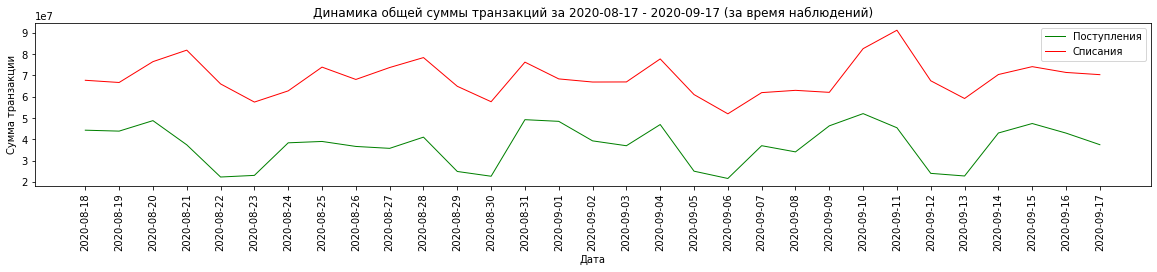

In [77]:
plt.figure(figsize=(20,3))

start_date = '2020-08-17'
end_date = '2020-09-17'

mask = (transactions['transaction_dttm'] > start_date) & (transactions['transaction_dttm'] <= end_date)

plt.plot(transactions.loc[mask].loc[transactions['operation_type'] == 1].groupby('transaction_dttm')
         ['transaction_amt_abs'].sum().index, 
         transactions.loc[mask].loc[transactions['operation_type'] == 1].groupby('transaction_dttm')
         ['transaction_amt_abs'].sum(), 
         linewidth=1, label='Поступления', color='green')

plt.plot(transactions.loc[mask].loc[transactions['operation_type'] == 0].groupby('transaction_dttm')
         ['transaction_amt_abs'].sum().index, 
         transactions.loc[mask].loc[transactions['operation_type'] == 0].groupby('transaction_dttm')
         ['transaction_amt_abs'].sum(), 
         linewidth=1, label='Списания', color='red')

plt.title(f'Динамика общей суммы транзакций за {start_date} - {end_date}')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Сумма транзакции')

ax = plt.gca()

plt.legend()

plt.show() 


*   Видно, что динамика трат и поступлений зачастую совпадет.



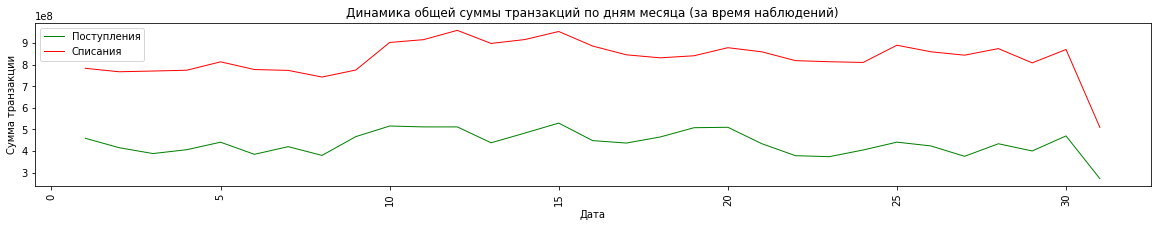

In [60]:
plt.figure(figsize=(20,3))

plt.plot(transactions.loc[transactions['operation_type'] == 1].groupby('day')
         ['transaction_amt_abs'].sum().index, 
         transactions.loc[transactions['operation_type'] == 1].groupby('day')
         ['transaction_amt_abs'].sum(), 
         linewidth=1, label='Поступления', color='green')

plt.plot(transactions.loc[transactions['operation_type'] == 0].groupby('day')
         ['transaction_amt_abs'].sum().index, 
         transactions.loc[transactions['operation_type'] == 0].groupby('day')
         ['transaction_amt_abs'].sum(), 
         linewidth=1, label='Списания', color='red')

plt.title('Динамика общей суммы транзакций по дням месяца (за время наблюдений)')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Сумма транзакции')

ax = plt.gca()

plt.legend()

plt.show() 



*   Можно заметить скачок объема затрат и поступлений к концу месяца. Резкий спад объясняется отсутствием 31 дня в некоторых месяцах.
*   Также видна активность ближе к средним числам месяца.



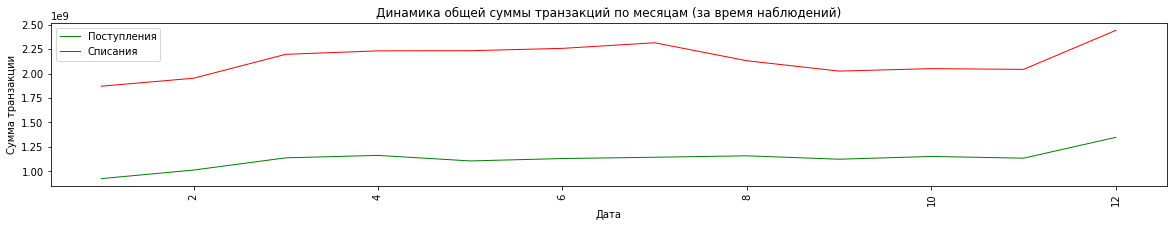

In [61]:
plt.figure(figsize=(20,3))

plt.plot(transactions.loc[transactions['operation_type'] == 1].groupby('month')
         ['transaction_amt_abs'].sum().index, 
         transactions.loc[transactions['operation_type'] == 1].groupby('month')
         ['transaction_amt_abs'].sum(), 
         linewidth=1, label='Поступления', color='green')

plt.plot(transactions.loc[transactions['operation_type'] == 0].groupby('month')
         ['transaction_amt_abs'].sum().index, 
         transactions.loc[transactions['operation_type'] == 0].groupby('month')
         ['transaction_amt_abs'].sum(), 
         linewidth=1, label='Списания', color='red')

plt.title('Динамика общей суммы транзакций по месяцам (за время наблюдений)')
plt.xlabel('Дата')
plt.xticks(rotation=90)
plt.ylabel('Сумма транзакции')

ax = plt.gca()

plt.legend()

plt.show() 



*   Заметна тенденция к меньшему количеству банковских операций в начале года и большему к концу года (особенно затрат к концу года).
*   Сейчас можно сделать вывод, что в данных гораздо большее количество операций списания.



_______________________________________________________________________________

# 4. Подготовка данных

Перед моделированием необходимо подготовить данные. Создадим фрейм, состоящий из различных статистических агрегаций transaction_amt по раннее выделенным признакам.

Потребуются две фукнции:

In [62]:
def __amnt_pivot_table_by_column_as_frame(frame, column, agg_funcs=None) -> pd.DataFrame:
    """
    Строит pivot table для между колонкой `transaction_amt` и column на основе переданных aggregations_on
    :param frame: pd.DataFrame транзакций
    :param column: название колонки, на основе `transaction_amt`  и column будет построен pivot_table
    :param agg_funcs: список из функций, которые нужно применить, по умолчанию ['mean', 'count']
    :return: pd.DataFrame
    """
    if agg_funcs is None:
        agg_funcs = ['mean', 'count']
    aggs = pd.pivot_table(frame, values='transaction_amt',
                          index=['user_id'], columns=[column],
                          aggfunc={'transaction_amt': agg_funcs},
                          fill_value=0.0)
    aggs.columns = [f'{col[0]}_{column}_{col[1]}' for col in aggs.columns.values]
    return aggs


def extract_basic_aggregations(transactions_frame: pd.DataFrame, cat_columns=None, agg_funcs=None) -> pd.DataFrame:
    """
    :param transactions_frame: pd.DataFrame с транзакциями
    :param cat_columns: список категориальных переменных, для которых будут построены агрегаты по `transaction_amt`
    :param agg_funcs: список функций, который нужно применить для подсчета агрегатов, по умолчанию
    ['sum', 'mean', 'count']
    :return: pd.DataFrame с извлеченными признаками
    """
    if not cat_columns:
        cat_columns = CAT_COLUMNS

    pivot_tables = []
    for col in cat_columns:
        pivot_tables.append(__amnt_pivot_table_by_column_as_frame(transactions_frame, column=col,
                                                                  agg_funcs=agg_funcs))
    pivot_tables = pd.concat(pivot_tables, axis=1)

    aggs = {
        'transaction_amt': ['mean', 'median', 'sum', 'std', 'count']} # посчитаем статистики для транзакций

    numeric_stats = transactions_frame.groupby(['user_id']).agg(aggs)

    numeric_stats.columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

    return pd.concat([pivot_tables, numeric_stats], axis=1).reset_index()

Выделим в контейнеры названия категориальных переменных и агрегируемые переменные.

In [63]:
CAT_COLUMNS = ['mcc_code', 'operation_type', 'currency_rk', 
               'day_of_week', 'hour', 'weekofyear', 
               'is_afternoon', 'early_morning'] 

REAL_COLUMNS = ['transaction_amt']

features_df = extract_basic_aggregations(transactions, cat_columns=CAT_COLUMNS)
features_df = reduce_mem_usage(features_df)

Memory usage of dataframe is 124.55 MB
Memory usage after optimization is: 52.26 MB
Decreased by 58.0%


Полученный фрейм готов к примению моделей ML.

In [64]:
features_df.head()

,user_id,count_mcc_code_-1,count_mcc_code_742,count_mcc_code_763,count_mcc_code_780,count_mcc_code_1520,count_mcc_code_1711,count_mcc_code_1731,count_mcc_code_1740,count_mcc_code_1750,...,mean_is_afternoon_1,count_early_morning_0,count_early_morning_1,mean_early_morning_0,mean_early_morning_1,transaction_amt_mean,transaction_amt_median,transaction_amt_sum,transaction_amt_std,transaction_amt_count
0,000932580e404dafbecd5916d4640938,6,0,0,0,0,0,0,0,0,...,-774.5,708,137,-341.5,425.761078,-217.125,-122.1875,-1.834270e+05,3230.144531,845
1,0009e36b42cb4caeb928a1e596819495,2,0,0,0,0,0,0,0,0,...,-1098.0,621,127,-974.5,-886.041504,-959.500,-271.5000,-7.176781e+05,2866.268555,748
2,000b29acb6bd44f99473c1be5ca28f3c,36,0,0,0,0,0,0,0,0,...,3772.0,655,314,919.0,636.512512,827.500,-264.2500,8.016948e+05,20551.343750,969
3,000c5327d99941fe934169838c65b92c,27,1,0,0,0,0,0,0,0,...,1368.0,695,28,1041.0,19228.888672,1745.000,-420.0000,1.261829e+06,27666.181641,723
4,000e0d54d7c945ebb8f6f855972e8396,11,0,0,0,0,0,0,0,0,...,-282.0,725,304,-370.0,-490.133148,-405.500,-213.2500,-4.172423e+05,2457.784912,1029


Объединим полученные признаки с трейн и тест данными по полю user_id.

In [65]:
merged_data = train.merge(features_df, how="left", on="user_id")
merged_test = test.merge(features_df, how="left", on="user_id")

In [66]:
features = [x for x in merged_data.columns if x not in ['user_id', 'higher_education']] # список используемых признаков

# 5. Обучение моделей

## Baseline model

Для получения первой модели используем бустинговый классификатор из библиотеки LightGBM.

In [67]:
targets = merged_data.higher_education.values

cv = KFold(n_splits=5, random_state=100, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

models_lgb = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 3,
    'reg_lambda': 1,
    'num_leaves': 64,
    'n_jobs': 5,
    'n_estimators': 1500
} # 0,781372

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[features], train.higher_education.values, eval_set=[(val[features], val.higher_education.values)],
              early_stopping_rounds=50, verbose=200)

    
    oof[val_idx] = lgb_model.predict_proba(val[features])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)
    models_lgb.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.777926
[400]	valid_0's auc: 0.788117
[600]	valid_0's auc: 0.792553
[800]	valid_0's auc: 0.793649
Early stopping, best iteration is:
[772]	valid_0's auc: 0.793818
Training with fold 1 completed.
Training with fold 2 started.
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.766648
[400]	valid_0's auc: 0.775737
[600]	valid_0's auc: 0.778929
[800]	valid_0's auc: 0.780744
[1000]	valid_0's auc: 0.781922
[1200]	valid_0's auc: 0.783133
[1400]	valid_0's auc: 0.783519
Early stopping, best iteration is:
[1375]	valid_0's auc: 0.783723
Training with fold 2 completed.
Training with fold 3 started.
Training until validation scores don't improve for 50 rounds
[200]	valid_0's auc: 0.773502
[400]	valid_0's auc: 0.787827
[600]	valid_0's auc: 0.793768
[800]	valid_0's auc: 0.7966
[1000]	valid_0's auc: 0.79866
[1200]	valid_0's auc: 0.799073
Early stopping, best

ROC-AUC скор модели для Train и CV выборок:

In [68]:
print('Train roc-auc', roc_auc_score(targets, train_preds))
print('CV roc-auc', roc_auc_score(targets, oof))

Train roc-auc 0.9070999428844053
CV roc-auc 0.7907806245200886


Для интерпретации модели используем технику SHAP.

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


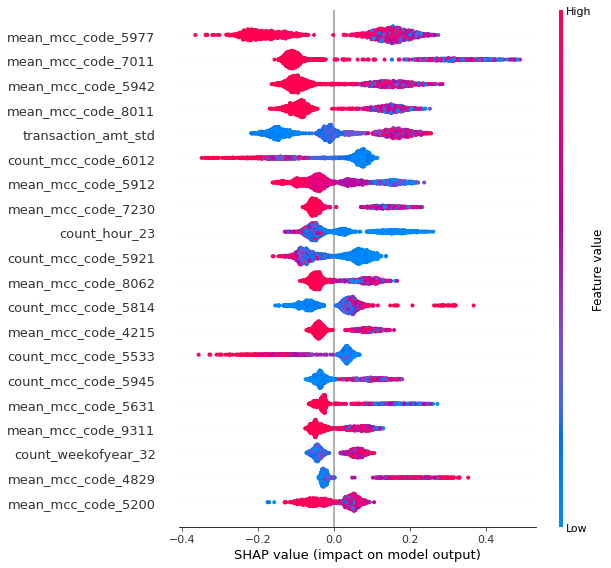

In [69]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(val[features])
shap.summary_plot(shap_values[1], val[features])

Чем меньше значение переменной (голубой цвет) - тем большие траты, чем больше значение (красный цвет) - тем меньшие траты.
Некоторые выводы:
* Уменьшение средних трат на категорию "Магазины косметики" (mean_mcc_code_5977) ведет к уменьшению вероятности, что клиент имеет высшее образование.
* Меньшие средние траты на категорию "Отели и мотели - нигде более не классифицированные" (mean_mcc_code_7011) чаще встречаются у клиентов без высшего образования, увеличение трат на отели постенно ведет к значительному увеличению вероятности ВО.
* Уменьшение средних трат на категорию "Магазины косметики" (mean_mcc_code_5977) ведет к уменьшению вероятности, что клиент имеет высшее образование.
* Имеют больше затраты на категорию "Финансовые учреждения – торговля и услуги" (mean_mcc_code_6012) преимущественно клиенты с ВО. Значения затрат, близкие к 0, значительно понижают шансы на ВО.
* Уменьшение средних трат на категорию "Фастфуд" (mean_mcc_code_5814) ведет к увеличению вероятности ВО.
* У клиентов без ВО в подавляющем большинстве низкие затраты на категорию "Товары для дома" (mean_mcc_code_5200).
* Увеличение средних трат на категорию "Автозапчасти и аксессуары" (mean_mcc_code_5533) ведет к увеличению вероятности ВО.

Есть основания полагать, что траты именно на эти решающие категории с некоторой надежностью свидетельствуют о возрасте клиента, что позволяет давать большую вероятность наличия ВО. Эту информацию также можно использовать для дальнейшего feature engineering.

## Blending моделей

Для повышения точности предсказания я буду использовать библиотеку Сбер LightAutoML, позволяющую автоматически тюнить и совмещать результаты работы моделей.

Задаем настройки и параметры модели:

In [70]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 600
TARGET_NAME = 'higher_education'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

task = Task('binary')

roles = {
    'target': TARGET_NAME,
    'drop': 'user_id',
}

Инициируем экземпляр модели:

In [71]:
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
    # general_params = {'use_algos': [['lgb', 'lgb_tuned']]},
    # tuning_params = {'max_tuning_iter': 20, 'max_tuning_time': 30}
)

Обучаем модели:

In [72]:
oof_pred = automl.fit_predict(merged_data, roles=roles, verbose=1)

[11:35:09] Start automl utilizator with listed constraints:
[11:35:09] - time: 600.00 seconds
[11:35:09] - CPU: 4 cores
[11:35:09] - memory: 16 GB

[11:35:09] If one preset completes earlier, next preset configuration will be started

[11:35:09] ==================================================
[11:35:09] Start 0 automl preset configuration:
[11:35:09] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[11:35:09] Stdout logging level is INFO.
[11:35:10] Task: binary

[11:35:10] Start automl preset with listed constraints:
[11:35:10] - time: 600.00 seconds
[11:35:10] - CPU: 4 cores
[11:35:10] - memory: 16 GB

[11:35:10] Train data shape: (8509, 967)

[11:35:29] Layer 1 train process start. Time left 581.01 secs
[11:35:31] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:35:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7884296033350305
[11:35:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicti

Получаем предсказание целевой переменной задачи Education.

In [75]:
pred = automl.predict(merged_test[features])
pred

array([[0.7401953 ],
       [0.81642723],
       [0.9457256 ],
       ...,
       [0.7072598 ],
       [0.5264425 ],
       [0.77464867]], dtype=float32)

In [76]:
test_sub = test.rename(columns={'user_id': 'bank'})
test_sub["higher_education_proba"] = pred.data[:, 0]
test_sub.to_csv("submission.csv", index=False)
test_sub.head()

,bank,higher_education_proba
0,85ef628894e34ad6869778a9a5d15ba5,0.740195
1,5ec7a78c6efd4d6291e371a6f30ed5c0,0.816427
2,d0f5d1884ad74e3e9aae7e49f2e1b77b,0.945726
3,c3c0f24dda94413ab98036f6d9018d3d,0.994191
4,6a137054df2a42218a518479317e5b1e,0.652679


Результат на данный момент: ROC-AUC 0,799014 (4/54 на public LB).

To do: 


*   генерация новых признаков и отбор существующих;
*   нейросетевой подход с LSTM с последовательностями транзакций и получением эмбеддингов клиентов.

